# Ensemble of Classifiers

In [4]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [5]:
#carregando os dados
df = pd.read_csv("../dataset/bank-preprocessed.csv")

#dimensoes da base de dados
print(df.shape)

#convertendo os valores da base para array
X = df.drop(columns=['y', 'duration'])
y = df['y']

(43294, 46)


## Defining train, test and making initial models

In [7]:
#semente de numeros aleatorios
seed = 42

#divisao dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)

#numero de folds atraves do metodo k-fold
kfold = StratifiedKFold(n_splits=10)

#criando o classificadores
rf = RandomForestClassifier(random_state=seed)
dt = DecisionTreeClassifier()

rf_results = cross_val_score(rf, X_train, y_train, cv=kfold)
rf = rf.fit(X_train, y_train)

print("Random Forest folds:", rf_results)
print("Media acurácia CV: " , rf_results.mean())
print("Acurácia teste: ", rf.score(X_test, y_test))


#treinamento da arvores de decisao em dez folds
dt_results = cross_val_score(dt, X_train, y_train, cv=kfold)
dt = dt.fit(X_train, y_train)

print("\nDecision Tree folds", dt_results)
print("Media acurácia CV: ", dt_results.mean())
print("Acurácia teste: ", dt.score(X_test,y_test))


'''lr_results = cross_val_score(lr, X_train, y_train, cv=kfold)
lr = svc.fit(X_train, y_train)

print("\LR folds", lr_results)
print("Media acurácia CV: ", lr_results.mean())
print("Acurácia teste: ", lr.score(X_test, y_test))'''

Random Forest folds: [0.89178489 0.89211481 0.89772352 0.89376443 0.88881557 0.89240924
 0.89141914 0.89108911 0.89471947 0.89372937]
Media acurácia CV:  0.8927569569890015
Acurácia teste:  0.8945261375009623

Decision Tree folds [0.82909931 0.82612999 0.8317387  0.8317387  0.82645991 0.82673267
 0.82112211 0.82574257 0.82673267 0.83564356]
Media acurácia CV:  0.828114020903905
Acurácia teste:  0.8347062899376395


'lr_results = cross_val_score(lr, X_train, y_train, cv=kfold)\nlr = svc.fit(X_train, y_train)\n\nprint("\\LR folds", lr_results)\nprint("Media acurácia CV: ", lr_results.mean())\nprint("Acurácia teste: ", lr.score(X_test, y_test))'

**Random Forest was the best classifier had a mean accuracy of ˜0.89, so we expect to get better values using ensembles.**

## Voting ensemble with AdaBoost

In [33]:
#Comitê com votação entre os classificadores com AdaBoostClassifier

import numpy as np
from sklearn.ensemble import AdaBoostClassifier

seed = 42

#training ensembles of classifiers
clf_array = [rf, dt]
clf_results = [rf_results, dt_results]

for (clf, result) in zip(clf_array, clf_results):
    boosting_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=3, random_state=seed)
    boosting_scores = cross_val_score(boosting_clf, X_train, y_train, cv=10)    
    print('Media clf ', result.mean(), 'Desvio ', result.std()) 
    print('Media Bagging', boosting_scores.mean(), 'Desvio ', boosting_scores.std())

Media clf  0.8927569569890015 Desvio  0.0022817318072031
Media Bagging 0.8932520936026298 Desvio  0.002405322016751064
Media clf  0.828774108687675 Desvio  0.0052980158949433595
Media Bagging 0.829367743438811 Desvio  0.004661503259299052


By applying the ensemble, we find better results in the random forest and decision tree model, but thats a very small gain.

We also tried to use SVC and Ridge as a base estimator but it failed to converge, we believe it's due to the unbalanced nature of the data we have.

## Voting Ensemble with Bagging

In [35]:
from sklearn.ensemble import BaggingClassifier

clf_array = [rf, dt]
clf_results = [rf_results, dt_results]

for (clf, result) in zip(clf_array, clf_results):
    bagging_clf = BaggingClassifier(clf, max_samples=0.3, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X_train, y_train, cv=10)    
    print('Media clf ', result.mean(), 'Desvio ', result.std()) 
    print('Media Bagging', bagging_scores.mean(), 'Desvio ', bagging_scores.std())

Media clf  0.8927569569890015 Desvio  0.0022817318072031
Media Bagging 0.8940769801163555 Desvio  0.0024869061294534264
Media clf  0.829302063495693 Desvio  0.0048642451462339665
Media Bagging 0.8891603921197134 Desvio  0.003415141197548848


As you can see, bagging with decision trees achieved a better result than the decision tree alone, but it was no better than the Random Forest alone. We can conclude that using Random Forest alone is the best option, in terms both of practicality and computational resources.

## Voting Ensemble for Classification

In [11]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

kfold = StratifiedKFold(n_splits=10, random_state=seed,shuffle=True)

# create the sub models
estimators = []
model1 = rf
estimators.append(('random forest', rf))

model2 = dt
estimators.append(('decision tree', dt))

mlp = MLPClassifier()
mlp.fit(X_train, y_train)

model3 = mlp
estimators.append(('mlp', mlp))

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

model4 = knn
estimators.append(('knn', knn))

# create the ensemble model
ensemble = VotingClassifier(estimators)
results = cross_val_score(ensemble, X_train, y_train, cv=kfold)
print(results.mean())

0.889522971102785


The result with voting ensemble was no better than the Random Forest alone.

## Comparing Ensemble to each baseline classifier

>dt 0.831 (0.004)
>knn 0.878 (0.002)
>mlp 0.876 (0.026)
>rf 0.894 (0.003)
>stacking 0.845 (0.052)


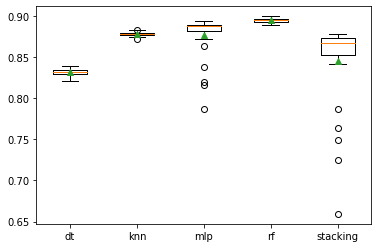

In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
from numpy import mean, std
 
# get the dataset
def get_dataset():
	df = pd.read_csv('../dataset/bank-preprocessed.csv')
	X = df.drop(columns=['y', 'duration'])
	y = df['y']
	return X, y
 
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('mlp', MLPClassifier()))
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('dt', DecisionTreeClassifier()))
	level0.append(('rf', RandomForestClassifier()))

	# define meta learner model
	level1 = LogisticRegression()

	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

	return model
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['dt'] = dt
	models['knn'] = knn
	models['mlp'] = mlp
	models['rf'] = rf
	models['stacking'] = get_stacking()

	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=5, error_score='raise')
	return scores
 
# define dataset
X, y = get_dataset()

# get the models to evaluate
models = get_models()

# evaluate the models and store results

results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Even using stacking, Random Forest was the best model in terms of accuracy and it had a way smaller variance, shown by the height of the box. And KNN and the MLP still got better results than stacking.